# Тема: Рекуррентные нейронные сети

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from keras.models import Sequential
from keras.layers import Flatten, Conv1D, LSTM, Dense
from keras.callbacks import EarlyStopping
from keras.preprocessing import timeseries_dataset_from_array

import warnings
warnings.simplefilter("ignore")

### 1. Попробуйте обучить нейронную сеть RNN/LSTM/GRU на любом другом датасете (любимый временной ряд, текст на русском (другом языке) как генератор или классификатор, или прилагаемый набор airline-passengers - пасажиропоток для авиалиний).

In [2]:
!wget 'https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb' -O data/airline-passengers.csv

--2021-05-07 13:56:42--  https://drive.google.com/uc?export=download&id=1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb
Распознаётся drive.google.com (drive.google.com)… 64.233.162.194, 2a00:1450:4010:c05::c2
Подключение к drive.google.com (drive.google.com)|64.233.162.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 302 Moved Temporarily
Адрес: https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dsh7jrsfk14p0v9itdvk6r8ga21or63j/1620384975000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2021-05-07 13:56:43--  https://doc-08-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dsh7jrsfk14p0v9itdvk6r8ga21or63j/1620384975000/14904333240138417226/*/1xwXieDVy1RKdfiJ6am_nNWp6XhAYdhNb?e=download
Распознаётся doc-08-c0-docs.googleusercontent.com (doc-08-c0-docs.googleusercontent.com)… 173.194.73.132, 2a00:1450:4010:c0d::84
Подключение

In [3]:
data = pd.read_csv('data/airline-passengers.csv')
data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
spam = data['Month'].str.split("-", expand=True)
data['year'] = spam[0]
data['month'] = spam[1]
data.head()

,Month,Passengers,year,month
0,1949-01,112,1949,01
1,1949-02,118,1949,02
2,1949-03,132,1949,03
3,1949-04,129,1949,04
4,1949-05,121,1949,05


In [5]:
data = data.iloc[:, 1:]
print(data.shape)
data.head()

(144, 3)


,Passengers,year,month
0,112,1949,01
1,118,1949,02
2,132,1949,03
3,129,1949,04
4,121,1949,05


In [6]:
train_size = 90

# отступ теста от тренировки
bias = 5

# делим
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size + bias:]

train_data.shape, val_data.shape

((90, 3), (49, 3))

In [7]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [8]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,month
0,112,-1.502191,-1.537902
1,118,-1.502191,-1.247732
2,132,-1.502191,-0.957561
3,129,-1.502191,-0.667391
4,121,-1.502191,-0.377221


In [9]:
train_data.tail()

,Passengers,year,month
85,277,1.71679,-1.247732
86,317,1.71679,-0.957561
87,313,1.71679,-0.667391
88,318,1.71679,-0.377221
89,374,1.71679,-0.087051


In [10]:
# длина истории
x_len = 7

# горизонт предсказания
future = 1

# параметры модели для обучения
learning_rate = 0.001
batch_size = 16
epochs = 50

In [11]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

8 98
41 103


In [12]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((90, 2), (90,), (41, 2), (41,))

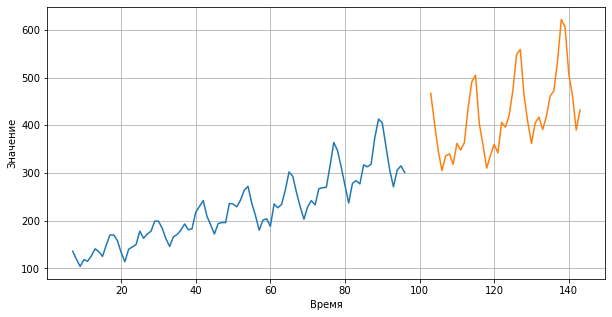

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.show()

In [14]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [15]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (16, 7, 2)
tf.Tensor(
[[-1.50219138 -1.24773159]
 [-1.50219138 -0.95756146]
 [-1.50219138 -0.66739132]
 [-1.50219138 -0.37722118]
 [-1.50219138 -0.08705104]
 [-1.50219138  0.2031191 ]
 [-1.50219138  0.49328923]], shape=(7, 2), dtype=float64)
Target shape: (16,)
tf.Tensor(119, shape=(), dtype=int64)


**сеть:  LSTM слои + Conv1D + Dense слой**

In [16]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Conv1D(64, 3, activation='linear'))
model.add(Conv1D(64, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(3, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 32)             4480      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 64)             6208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 963       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4

In [17]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/50
6/6 [==============================] - 2s 118ms/step - loss: 37725.6699 - mae: 185.2067 - val_loss: 170704.0000 - val_mae: 407.6030
Epoch 2/50
6/6 [==============================] - 0s 17ms/step - loss: 37583.6141 - mae: 184.8135 - val_loss: 170125.9531 - val_mae: 406.8999
Epoch 3/50
6/6 [==============================] - 0s 17ms/step - loss: 37415.7665 - mae: 184.4079 - val_loss: 169031.5781 - val_mae: 405.5651
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 37062.7478 - mae: 183.5499 - val_loss: 166654.2188 - val_mae: 402.6502
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 36287.1855 - mae: 181.6587 - val_loss: 161285.8438 - val_mae: 395.9888
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 34559.3178 - mae: 177.3935 - val_loss: 149200.6250 - val_mae: 380.5612
Epoch 7/50
6/6 [==============================] - 0s 15ms/step - loss: 30775.1253 - mae: 167.6827 - val_loss: 123455.3750 - val_mae: 345.3845
Epoch

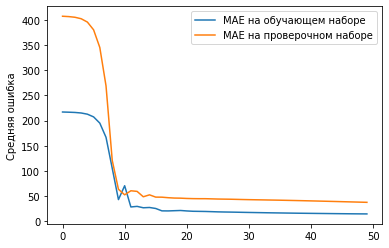

In [18]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [19]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/50
6/6 [==============================] - 0s 17ms/step - loss: 326.6250 - mae: 14.2192 - val_loss: 1915.9071 - val_mae: 37.0177
Epoch 2/50
6/6 [==============================] - 0s 16ms/step - loss: 323.5242 - mae: 14.1477 - val_loss: 1885.9170 - val_mae: 36.6930
Epoch 3/50
6/6 [==============================] - 0s 16ms/step - loss: 320.5341 - mae: 14.0753 - val_loss: 1856.5751 - val_mae: 36.3704
Epoch 4/50
6/6 [==============================] - 0s 16ms/step - loss: 317.6375 - mae: 14.0082 - val_loss: 1827.8650 - val_mae: 36.0504
Epoch 5/50
6/6 [==============================] - 0s 16ms/step - loss: 314.8182 - mae: 13.9404 - val_loss: 1799.7679 - val_mae: 35.7331
Epoch 6/50
6/6 [==============================] - 0s 16ms/step - loss: 312.0649 - mae: 13.8769 - val_loss: 1772.2701 - val_mae: 35.4187
Epoch 7/50
6/6 [==============================] - 0s 16ms/step - loss: 309.3682 - mae: 13.8140 - val_loss: 1745.3519 - val_mae: 35.1073
Epoch 8/50
6/6 [==============================] 

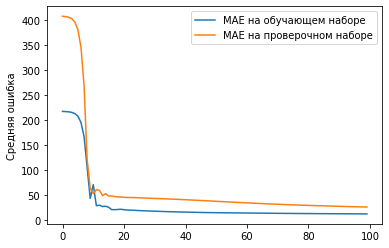

In [20]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])


plt.plot(hist_train, 
         label='MAE на обучающем наборе')
plt.plot(hist_val, 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [21]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

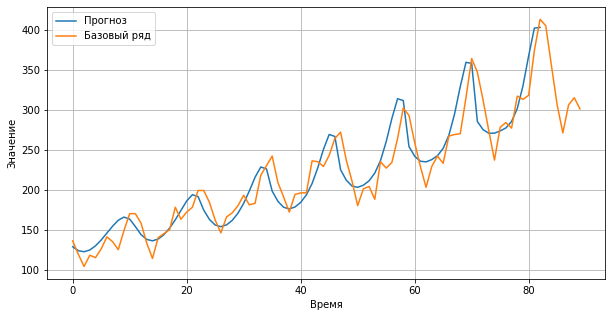

In [22]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

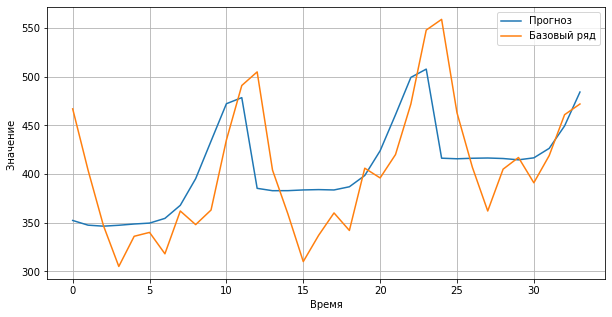

In [23]:
start = 0
step = 34
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

### 2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [24]:
mean_absolute_error(y_val.flatten()[start: start+step], pred_val[future + start: future + start + step])

37.299693388097424

Точность модели улучшилась за счет увеличения количества epochs и уменьшения batch_size